Importing Important Libraries

In [44]:
import warnings
import math
warnings.filterwarnings('ignore')

# import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Plots and stats
import matplotlib.pyplot as plt
import seaborn as sns

# Label Encoding & Scaling
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

# Model Building
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Importing Dataset

In [45]:
df = pd.read_csv("credit_risk_dataset_NEW.csv.xls")
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


Data Cleaning

In [46]:
# Copying DataFrame df
df_encoded = df.copy()

# Define label encoders and columns to encode
label_encoders = {}
columns_to_encode = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Encoding categorical columns and replacing them with encoded versions
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    df_encoded[column] = label_encoders[column].fit_transform(df_encoded[column])

df_encoded.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,123.0,4,3,35000,16.02,1,0.59,1,3
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4


In [47]:
# Loop through each column to check encoding
for column in columns_to_encode:
    original_values = df[column].unique()
    encoded_column = column
    encoded_values = df_encoded[encoded_column].unique()

    print(f"{column}:")
    for orig, enc in zip(original_values, encoded_values):
        print(f"'{orig}' in df --> '{enc}'")

person_home_ownership:
'RENT' in df --> '3'
'OWN' in df --> '2'
'MORTGAGE' in df --> '0'
'OTHER' in df --> '1'
loan_intent:
'PERSONAL' in df --> '4'
'EDUCATION' in df --> '1'
'MEDICAL' in df --> '3'
'VENTURE' in df --> '5'
'HOMEIMPROVEMENT' in df --> '2'
'DEBTCONSOLIDATION' in df --> '0'
loan_grade:
'D' in df --> '3'
'B' in df --> '1'
'C' in df --> '2'
'A' in df --> '0'
'E' in df --> '4'
'F' in df --> '5'
'G' in df --> '6'
cb_person_default_on_file:
'Y' in df --> '1'
'N' in df --> '0'


In [48]:
df_encoded['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
0    26836
1     5745
Name: count, dtype: int64

In [49]:
df_encoded.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [50]:
df_encoded.describe()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,31686.000000,32581.000000,32581.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,1.676222,4.789686,2.533839,1.218195,9589.371106,11.011695,0.218164,0.170203,0.176330,5.804211
std,6.348078,6.198312e+04,1.433116,4.142630,1.731182,1.166336,6322.086646,3.240459,0.413006,0.106782,0.381106,4.055001
min,20.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,0.000000,2.000000,1.000000,0.000000,5000.000000,7.900000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.500000e+04,3.000000,4.000000,3.000000,1.000000,8000.000000,10.990000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,7.920000e+04,3.000000,7.000000,4.000000,2.000000,12200.000000,13.470000,0.000000,0.230000,0.000000,8.000000
max,144.000000,6.000000e+06,3.000000,123.000000,5.000000,6.000000,35000.000000,23.220000,1.000000,0.830000,1.000000,30.000000


In [51]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  int64  
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  int64  
 5   loan_grade                  32581 non-null  int64  
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  int64  
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 3.0 MB


In [52]:
df_encoded.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [53]:
#Filling NA/missing values
df_encoded.fillna(df_encoded["loan_int_rate"].mean(),inplace=True)
df_encoded.fillna(df_encoded["person_emp_length"].mean(),inplace=True)

Coloumn Selection

In [54]:
X = df_encoded.drop(columns=['cb_person_default_on_file'])
Y = df_encoded['cb_person_default_on_file']

Splitting Sets

In [55]:
# Split the dataset into training and temporary set (60% training, 40% temp set)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)

# Further split the temporary set into validation and test sets (50% validation, 50% test)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Print the shapes of each set to verify the proportions
print("Training set shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("\nValidation set shapes:")
print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)
print("\nTest set shapes:")
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


Training set shapes:
X_train: (19548, 11)
Y_train: (19548,)

Validation set shapes:
X_val: (6516, 11)
Y_val: (6516,)

Test set shapes:
X_test: (6517, 11)
Y_test: (6517,)


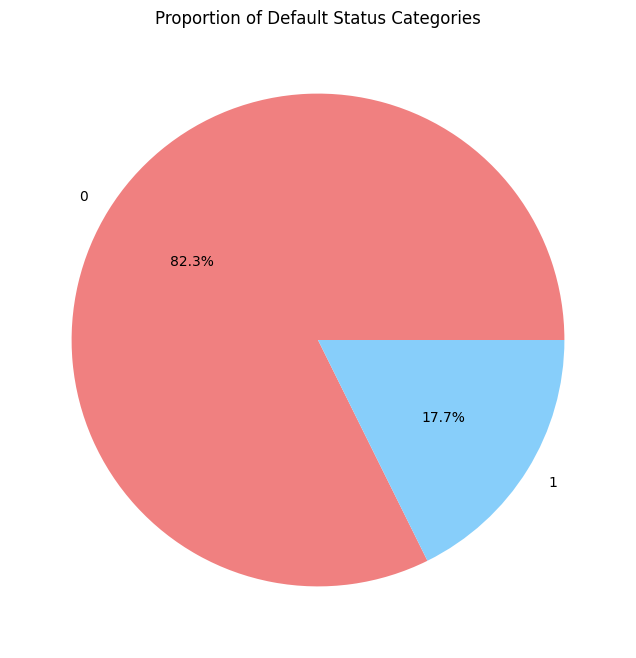

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the training dataset based on your split
training_df = df_encoded.loc[X_train.index]

# Count the occurrences of each category
counts = training_df['cb_person_default_on_file'].value_counts()

# Create a pie chart for category 0
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=["lightcoral", "lightskyblue"])
plt.title("Proportion of Default Status Categories")
plt.show()


Correcting the Imbalance

In [57]:
# import library
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X_train, Y_train)

print('original dataset shape:', Counter(Y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 16093, 1: 3455})
Resample dataset shape Counter({0: 3455, 1: 3455})


Scaling Of Features

In [58]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_rus)
X_test_scaled = scaler.transform(X_test)

Decision tree

In [59]:
X_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
19718,28,35328,0,12.0,0,0,13000,11.011695,0,0.37,9
27172,29,125000,0,2.0,3,2,3500,13.980000,0,0.03,8
8268,22,56902,0,6.0,0,0,12000,7.140000,0,0.21,4
1836,22,30000,2,3.0,1,2,8000,13.490000,0,0.27,2
29903,37,59000,3,2.0,1,3,4800,14.540000,1,0.08,14
...,...,...,...,...,...,...,...,...,...,...,...
29802,39,38500,0,7.0,3,2,3500,13.980000,0,0.09,17
5390,25,69000,3,5.0,2,0,8500,6.920000,1,0.12,4
860,26,148000,3,1.0,0,4,20000,17.990000,1,0.14,3
15795,26,175000,0,0.0,4,2,15000,11.011695,0,0.09,3


In [60]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Function to add text below the x-axis label
# def add_text_below(ax, text):
#     ax.text(0.5, -0.15, text, transform=ax.transAxes, ha='center', fontsize=10)

# # Function to create histogram and add text below the graph
# def create_histogram_with_text(data, x_label, title, text):
#     plt.figure(figsize=(8, 6))
#     sns.histplot(data, bins=20, kde=True)
#     plt.xlabel(x_label)
#     plt.ylabel('Frequency')
#     plt.title(title)
#     add_text_below(plt.gca(), text)
#     plt.show()

# # 1. person_age
# create_histogram_with_text(df['person_age'], 'Age (years)', 'Distribution of Borrower Age',
#                            'Most borrowers are in their 20s and 30s')

# # 2. person_income
# create_histogram_with_text(df['person_income'], 'Income ($)', 'Distribution of Borrower Income',
#                            'Income distribution is right-skewed')

# # 3. person_home_ownership
# plt.figure(figsize=(8, 6))
# sns.countplot(data=df, x='person_home_ownership')
# plt.xlabel('Home Ownership')
# plt.ylabel('Count')
# plt.title('Distribution of Home Ownership Status')
# add_text_below(plt.gca(), 'Majority of borrowers own a home')
# plt.show()

# # 4. person_emp_length
# create_histogram_with_text(df['person_emp_length'], 'Employment Length (years)', 
#                            'Distribution of Borrower Employment Length',
#                            'Employment length is right-skewed')

# # 5. loan_intent
# plt.figure(figsize=(10, 6))
# sns.countplot(data=df, x='loan_intent')
# plt.xlabel('Loan Intent')
# plt.ylabel('Count')
# plt.title('Distribution of Loan Intent')
# plt.xticks(rotation=45)
# add_text_below(plt.gca(), 'Debt consolidation is the most common intent')
# plt.show()

# # 6. loan_grade
# plt.figure(figsize=(8, 6))
# sns.countplot(data=df, x='loan_grade', order=sorted(df['loan_grade'].unique()))
# plt.xlabel('Loan Grade')
# plt.ylabel('Count')
# plt.title('Distribution of Loan Grade')
# add_text_below(plt.gca(), 'Majority of loans are grade B and C')
# plt.show()

# # 7. loan_amnt
# create_histogram_with_text(df['loan_amnt'], 'Loan Amount ($)', 'Distribution of Loan Amount',
#                            'Loan amounts are right-skewed')

# # 8. loan_int_rate
# create_histogram_with_text(df['loan_int_rate'], 'Interest Rate (%)', 'Distribution of Interest Rate',
#                            'Interest rates are normally distributed')

# # 9. loan_status
# plt.figure(figsize=(8, 6))
# sns.countplot(data=df, x='loan_status')
# plt.xlabel('Loan Status')
# plt.ylabel('Count')
# plt.title('Distribution of Loan Status')
# add_text_below(plt.gca(), 'Most loans are fully paid')
# plt.show()

# # 10. loan_percent_income
# create_histogram_with_text(df['loan_percent_income'], 'Loan Percentage of Income (%)',
#                            'Distribution of Loan Percentage of Income',
#                            'Loan percentage of income is right-skewed')

# # 11. cb_person_default_on_file
# plt.figure(figsize=(8, 6))
# sns.countplot(data=df, x='cb_person_default_on_file')
# plt.xlabel('Default History')
# plt.ylabel('Count')
# plt.title('Distribution of Default History')
# add_text_below(plt.gca(), 'Most borrowers have no default history')
# plt.show()

# # 12. cb_person_cred_hist_length
# create_histogram_with_text(df['cb_person_cred_hist_length'], 'Credit History Length (years)',
#                            'Distribution of Credit History Length',
#                            'Credit history lengths are right-skewed')


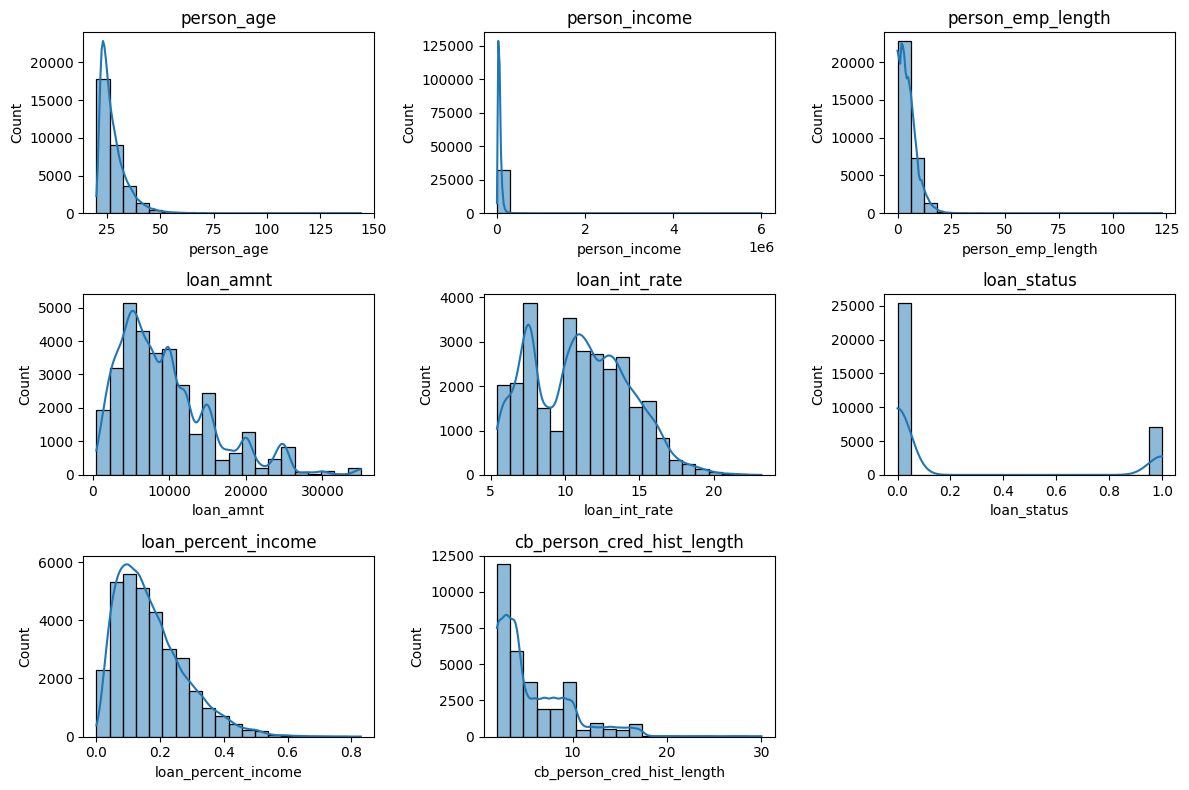

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (assuming it's stored in a DataFrame called 'df')
# Example: df = pd.read_csv('your_dataset.csv')

# Select only numeric columns for correlation calculation
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
numeric_df = df[numeric_columns]

# Plot histograms for numerical variables
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

In [62]:
from sklearn.tree import DecisionTreeClassifier
treemodel = DecisionTreeClassifier() #gini is default criterion which is in between 0 and 0.5
treemodel.fit(X_train, Y_train)
second_treemodel = DecisionTreeClassifier(max_depth=4)
second_treemodel.fit(X_train, Y_train)


DecisionTreeClassifier(max_depth=4)

[Text(0.4375, 0.9, 'x[5] <= 1.5\ngini = 0.291\nsamples = 19548\nvalue = [16093, 3455]'),
 Text(0.375, 0.7, 'gini = 0.0\nsamples = 12759\nvalue = [12759, 0]'),
 Text(0.5, 0.7, 'x[9] <= 0.125\ngini = 0.5\nsamples = 6789\nvalue = [3334, 3455]'),
 Text(0.25, 0.5, 'x[1] <= 13366.0\ngini = 0.497\nsamples = 2403\nvalue = [1113, 1290]'),
 Text(0.125, 0.3, 'x[10] <= 5.5\ngini = 0.298\nsamples = 11\nvalue = [9, 2]'),
 Text(0.0625, 0.1, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.1875, 0.1, 'gini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.375, 0.3, 'x[4] <= 3.5\ngini = 0.497\nsamples = 2392\nvalue = [1104, 1288]'),
 Text(0.3125, 0.1, 'gini = 0.494\nsamples = 1612\nvalue = [720, 892]'),
 Text(0.4375, 0.1, 'gini = 0.5\nsamples = 780\nvalue = [384, 396]'),
 Text(0.75, 0.5, 'x[1] <= 67119.5\ngini = 0.5\nsamples = 4386\nvalue = [2221, 2165]'),
 Text(0.625, 0.3, 'x[3] <= 18.5\ngini = 0.499\nsamples = 3209\nvalue = [1667.0, 1542.0]'),
 Text(0.5625, 0.1, 'gini = 0.499\nsamples = 3196\nvalue 

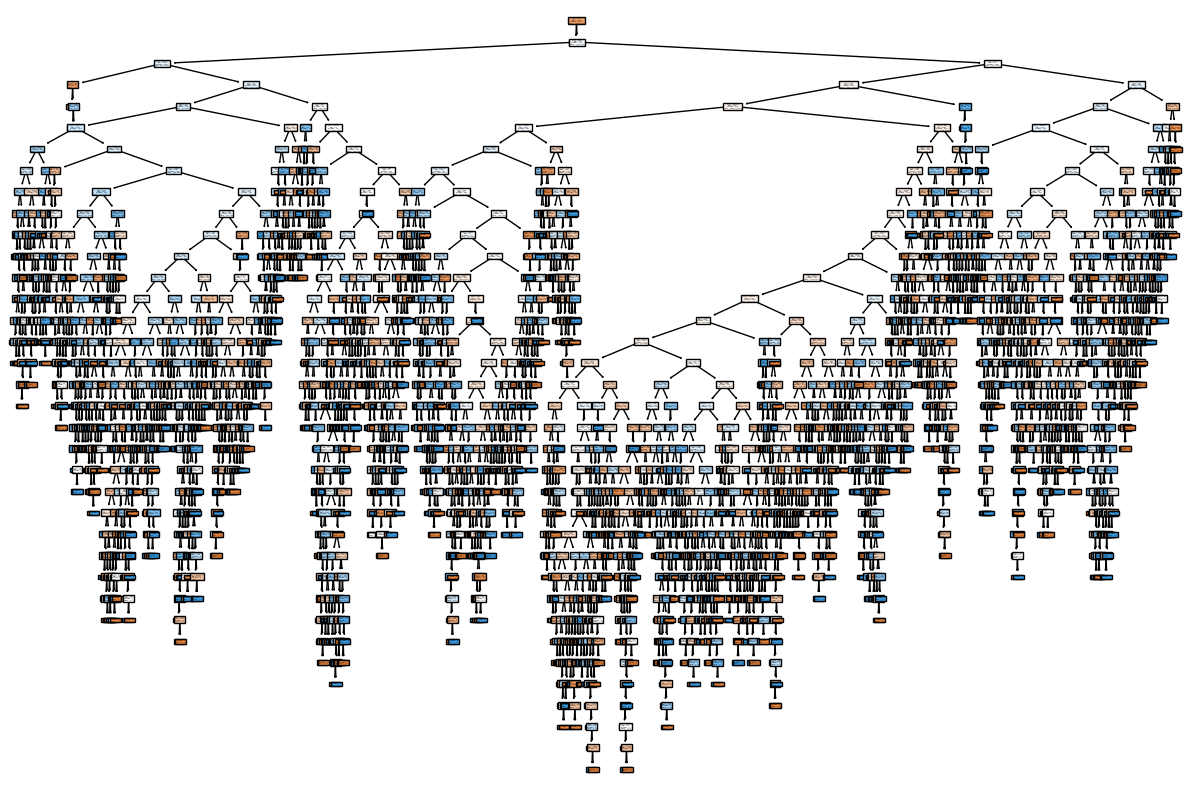

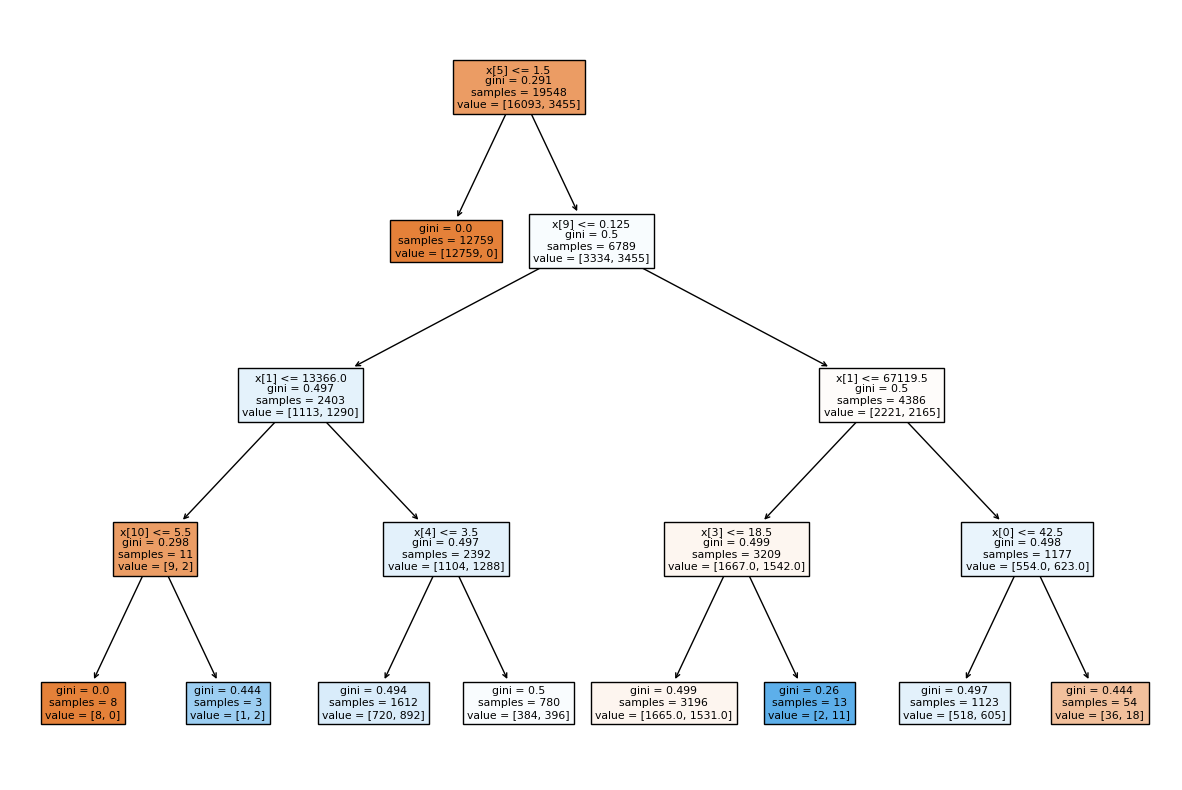

In [63]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(treemodel, filled=True)

plt.figure(figsize=(15,10))
tree.plot_tree(second_treemodel, filled=True)


In [64]:
y_pred =treemodel.predict(X_test)

In [65]:
print(y_pred)  

[0 1 0 ... 0 1 0]


In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy: ", accuracy_score(y_pred,Y_test ))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

Accuracy:  0.8258401104802824

Confusion Matrix:
 [[4823  537]
 [ 598  559]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      5360
           1       0.51      0.48      0.50      1157

    accuracy                           0.83      6517
   macro avg       0.70      0.69      0.70      6517
weighted avg       0.82      0.83      0.82      6517



In [67]:
#preprunning
parameter = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_features": ["auto", "sqrt", "log2"], 
}

In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
treemodel  = DecisionTreeClassifier()
cv = GridSearchCV(treemodel, param_grid=parameter, cv=5,scoring='accuracy')

In [70]:
cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [71]:
cv.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'random'}

In [72]:
y_pred=cv.predict(X_test)

Accuracy:  0.8267607794997698


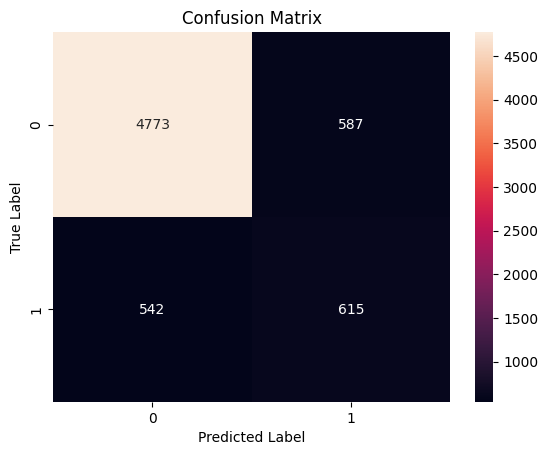


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      5360
           1       0.51      0.53      0.52      1157

    accuracy                           0.83      6517
   macro avg       0.70      0.71      0.71      6517
weighted avg       0.83      0.83      0.83      6517



In [73]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
print("Accuracy: ", accuracy_score(y_pred,Y_test ))


conf_matrix = confusion_matrix(Y_test, y_pred)

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:\n", classification_report(Y_test, y_pred))



Gradient boosting

Accuracy: 0.9257326990946755


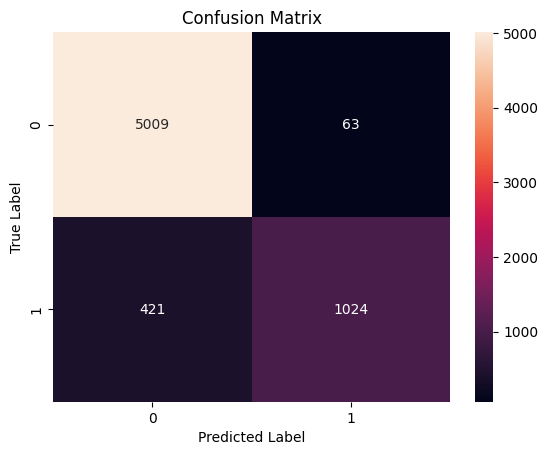


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      5072
           1       0.94      0.71      0.81      1445

    accuracy                           0.93      6517
   macro avg       0.93      0.85      0.88      6517
weighted avg       0.93      0.93      0.92      6517



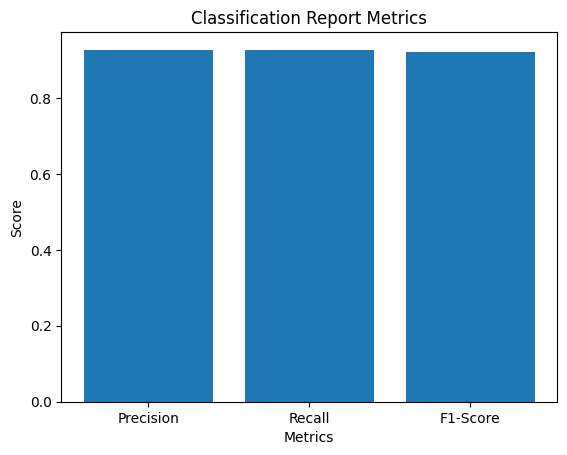

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate features (X) and target variable (y)
X = df.drop('loan_status', axis=1)  # Assuming 'loan_status' is the target variable
y = df['loan_status']

# Define categorical and numerical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numeric_columns = [col for col in X.columns if col not in categorical_columns]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_columns),  # impute missing values with median for numeric columns
        ('cat', OneHotEncoder(), categorical_columns)  # one-hot encode categorical columns
    ])

# Initialize Gradient Boosting classifier
gb_model = GradientBoostingClassifier()

# Create pipeline with preprocessing and Gradient Boosting classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', gb_model)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# ... your existing code ...

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)
import matplotlib.pyplot as plt
# Extract precision, recall, and F1-score from the classification report
report_data = classification_report(y_test, y_pred, output_dict=True)
precision = report_data['weighted avg']['precision']
recall = report_data['weighted avg']['recall']
f1_score = report_data['weighted avg']['f1-score']

# Create a bar plot
labels = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1_score]

plt.bar(labels, values)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Classification Report Metrics')
plt.show()
